# Importing the necessary libraries

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import random
import os

# Defining the constants

In [35]:
# Adjusted Constants
BATCH_SIZE = 8  # Increase batch size
EPOCHS = 5  # Reduce epochs if your model converges quickly
LEARNING_RATE = 0.001  # Optimize learning rate based on model performance
BETA = 0.75  # Fine-tune regularization parameters
GAMMA = 0.005

# Config of GPU

In [36]:
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        print("Name:", gpu.name, "  Type:", gpu.device_type)
else:
    print("No GPU detected")


Name: /physical_device:GPU:0   Type: GPU


In [37]:
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU detected")

1 Physical GPUs, 1 Logical GPU


# Data Preprocessing

In [38]:
def normalize_image(img):
    return tf.cast(img, tf.float32) / 255.0

def load_image(path, size=(224, 224)):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)

    # Assert the image has 3 channels (RGB)
    assert img.shape[-1] == 3, f"Expected RGB image but got shape {img.shape}"

    img = tf.image.resize(img, size)
    img = normalize_image(img)  # Normalize image
    return img

def load_data(files_list, batch_size):
    while True:
        batch_cover = []
        batch_secret = []
        for _ in range(batch_size):
            img_secret_path = random.choice(files_list)
            img_cover_path = random.choice(files_list)

            img_secret = load_image(img_secret_path)
            img_cover = load_image(img_cover_path)

            batch_cover.append(img_cover)
            batch_secret.append(img_secret)

        yield tf.stack(batch_cover), tf.stack(batch_secret)

# Define prep network using Keras functional API

In [39]:

def get_prep_network_op(secret_tensor):
    conv_7x7 = layers.Conv2D(75, 7, padding='same', activation='relu')(secret_tensor)
    conv_5x5 = layers.Conv2D(25, 5, padding='same', activation='relu')(secret_tensor)
    conv_3x3 = layers.Conv2D(25, 3, padding='same', activation='relu')(secret_tensor)

    concat_1 = layers.Concatenate(axis=3)([conv_7x7, conv_5x5, conv_3x3])

    conv_7x7_final = layers.Conv2D(75, 7, padding='same', activation='relu')(concat_1)
    conv_5x5_final = layers.Conv2D(25, 5, padding='same', activation='relu')(concat_1)
    conv_3x3_final = layers.Conv2D(25, 3, padding='same', activation='relu')(concat_1)

    concat_final = layers.Concatenate(axis=3)([conv_7x7_final, conv_5x5_final, conv_3x3_final])

    # Ensure the output shape is (None, 224, 224, 125)
    output = layers.Conv2D(125, 1, padding='same')(concat_final)

    return output

# Define hiding network using Keras functional API

In [40]:

def get_hiding_network_op(cover_tensor, prep_output):
    # Ensure prep_output has the correct shape (None, 224, 224, 125)
    prep_output_reshaped = layers.Reshape((224, 224, 125))(prep_output)

    concat_input = layers.Concatenate(axis=3)([cover_tensor, prep_output_reshaped])

    conv_7x7 = layers.Conv2D(75, 7, padding='same', activation='relu')(concat_input)
    conv_5x5 = layers.Conv2D(25, 5, padding='same', activation='relu')(concat_input)
    conv_3x3 = layers.Conv2D(25, 3, padding='same', activation='relu')(concat_input)

    concat_1 = layers.Concatenate(axis=3)([conv_7x7, conv_5x5, conv_3x3])

    conv_7x7_final = layers.Conv2D(75, 7, padding='same', activation='relu')(concat_1)
    conv_5x5_final = layers.Conv2D(25, 5, padding='same', activation='relu')(concat_1)
    conv_3x3_final = layers.Conv2D(25, 3, padding='same', activation='relu')(concat_1)

    concat_final = layers.Concatenate(axis=3)([conv_7x7_final, conv_5x5_final, conv_3x3_final])

    output = layers.Conv2D(3, 1, padding='same')(concat_final)

    return output



# Define reveal network using Keras functional API

In [41]:

def get_reveal_network_op(container_tensor):
    conv_7x7 = layers.Conv2D(75, 7, padding='same', activation='relu')(container_tensor)
    conv_5x5 = layers.Conv2D(25, 5, padding='same', activation='relu')(container_tensor)
    conv_3x3 = layers.Conv2D(25, 3, padding='same', activation='relu')(container_tensor)

    concat_1 = layers.Concatenate(axis=3)([conv_7x7, conv_5x5, conv_3x3])

    conv_7x7 = layers.Conv2D(75, 7, padding='same', activation='relu')(concat_1)
    conv_5x5 = layers.Conv2D(25, 5, padding='same', activation='relu')(concat_1)
    conv_3x3 = layers.Conv2D(25, 3, padding='same', activation='relu')(concat_1)

    concat_final = layers.Concatenate(axis=3)([conv_7x7, conv_5x5, conv_3x3])

    output = layers.Conv2D(3, 1, padding='same')(concat_final)

    return output

# Function to add noise layer

In [42]:

def get_noise_layer_op(tensor, std=0.1):
    noise = tf.random.normal(tf.shape(tensor), mean=0.0, stddev=std, dtype=tf.float32)
    return tensor + noise



# Function to calculate total loss

In [43]:
# Function to calculate SSIM loss using built-in TensorFlow function
def ssim_loss(true, pred, max_val=1.0):
    ssim = tf.image.ssim(true, pred, max_val=max_val)
    return 1.0 - ssim  # Subtract from 1 to get loss

# Function to calculate correlation loss
def correlation_loss(cover_true, container_input, secret_pred):
    cover_diff = tf.abs(cover_true - container_input)
    cover_diff_flat = tf.reshape(cover_diff, [tf.shape(cover_diff)[0], -1])
    secret_pred_flat = tf.reshape(secret_pred, [tf.shape(secret_pred)[0], -1])

    cover_mean = tf.reduce_mean(cover_diff_flat, axis=1, keepdims=True)
    secret_mean = tf.reduce_mean(secret_pred_flat, axis=1, keepdims=True)

    cover_diff_centered = cover_diff_flat - cover_mean
    secret_pred_centered = secret_pred_flat - secret_mean

    numerator = tf.reduce_sum(cover_diff_centered * secret_pred_centered, axis=1)
    denominator = tf.sqrt(tf.reduce_sum(tf.square(cover_diff_centered), axis=1) * tf.reduce_sum(tf.square(secret_pred_centered), axis=1))

    correlation = numerator / (denominator + 1e-8)  # Adding a small constant to prevent division by zero
    return 1 - correlation  # Subtract from 1 to get loss

def get_loss_op(secret_true, secret_pred, cover_true, container_input, beta=0.5, gamma=0.1):
    beta = tf.constant(beta, name="beta")
    gamma = tf.constant(gamma, name="gamma")

    secret_ssim = ssim_loss(secret_true, secret_pred)
    cover_ssim = ssim_loss(cover_true, container_input)

    cover_dist_loss = correlation_loss(cover_true, container_input, secret_pred)

    final_loss = cover_ssim + beta * secret_ssim + gamma * cover_dist_loss

    return final_loss, secret_ssim, cover_ssim, cover_dist_loss


# Define prep, hiding, and reveal networks using the functional API

In [44]:
class SteganographyModel(tf.keras.Model):
    def __init__(self):
        super(SteganographyModel, self).__init__()
        # Properly define inputs for the prep network
        secret_input = layers.Input(shape=(224, 224, 3))
        prep_output = get_prep_network_op(secret_input)
        self.prep_network = models.Model(inputs=secret_input, outputs=prep_output)

        # Define input for the cover image
        cover_input = layers.Input(shape=(224, 224, 3))

        # Ensure prep_output has the correct shape (None, 224, 224, 125)
        prep_output_reshaped = layers.Reshape((224, 224, 125))(prep_output)

        hiding_output = get_hiding_network_op(cover_input, prep_output_reshaped)
        self.hiding_network = models.Model(inputs=[cover_input, prep_output], outputs=hiding_output)

        # Properly define inputs for the reveal network
        container_input = layers.Input(shape=(224, 224, 3))
        reveal_output = get_reveal_network_op(container_input)
        self.reveal_network = models.Model(inputs=container_input, outputs=reveal_output)

    def call(self, secret_image, cover_image):
        prep_output = self.prep_network(secret_image)

        # Ensure prep_output is reshaped to (None, 224, 224, 125)
        prep_output_reshaped = layers.Reshape((224, 224, 125))(prep_output)

        hiding_output = self.hiding_network([cover_image, prep_output_reshaped])
        noise_output = get_noise_layer_op(hiding_output)
        reveal_output = self.reveal_network(noise_output)
        return hiding_output, reveal_output

# Instantiate the model & Defined optimizer and loss function

In [45]:
model = SteganographyModel()

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)


# Prepare training data

In [46]:
# Directory containing your image files
directory1 = "/content/sample_data/train"

# Get list of all files in the directory
train_files = os.listdir(directory1)

# Filter to keep only .jpg files (if necessary)
train_files = [os.path.join(directory1, f) for f in train_files if f.endswith('.jpg')]


# Directory containing your image files
directory2 = "/content/sample_data/test"

# Get list of all files in the directory
test_files = os.listdir(directory2)

# Filter to keep only .jpg files (if necessary)
test_files = [os.path.join(directory2, f) for f in test_files if f.endswith('.jpg')]


# Directory containing your image files
directory3 = "/content/sample_data/val"

# Get list of all files in the directory
val_files = os.listdir(directory3)

# Filter to keep only .jpg files (if necessary)
val_files = [os.path.join(directory3, f) for f in test_files if f.endswith('.jpg')]

train_data = load_data(train_files, BATCH_SIZE)
val_data = load_data(val_files, BATCH_SIZE)
test_data = load_data(test_files, BATCH_SIZE)

# Training loop

In [47]:
# Lists to store training and validation losses
train_loss = []
val_loss = []

for epoch in range(EPOCHS):
    epoch_train_loss = []

    print(f"Epoch {epoch+1}/{EPOCHS}")

    for step in range(len(train_files) // BATCH_SIZE):
        #print(f"  Training Step {step+1}/{len(train_files) // BATCH_SIZE}")

        cover_batch, secret_batch = next(train_data)

        if np.any(np.isnan(cover_batch)) or np.any(np.isnan(secret_batch)):
            print(f'NaN values found in data batch at epoch {epoch+1}, step {step+1}.')
            continue

        with tf.GradientTape() as tape:
            # Forward pass
            hiding_output, reveal_output = model(secret_batch, cover_batch)
            # Calculate loss
            loss, secret_ssim, cover_ssim, cover_dist = get_loss_op(
                secret_batch, reveal_output, cover_batch, hiding_output, beta=BETA, gamma=GAMMA)

        if tf.reduce_any(tf.math.is_nan(loss)):
            print(f'NaN loss encountered at epoch {epoch+1}, step {step+1}.')
            continue

        # Backpropagation
        gradients = tape.gradient(loss, model.trainable_variables)
        clipped_gradients, _ = tf.clip_by_global_norm(gradients, 1.0)  # Adjust clip_norm as needed
        optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))

        epoch_train_loss.append(loss.numpy())

    train_loss.append(np.mean(epoch_train_loss))

    # Validation
    epoch_val_loss = []
    for step in range(len(val_files) // BATCH_SIZE):
        #print(f"  Validation Step {step+1}/{len(val_files) // BATCH_SIZE}")

        cover_batch, secret_batch = next(val_data)

        if np.any(np.isnan(cover_batch)) or np.any(np.isnan(secret_batch)):
            print(f'NaN values found in validation data batch at epoch {epoch+1}, step {step+1}.')
            continue

        # Forward pass (no gradient calculation during validation)
        hiding_output, reveal_output = model(secret_batch, cover_batch)
        loss, _, _, _ = get_loss_op(secret_batch, reveal_output, cover_batch, hiding_output, beta=BETA, gamma=GAMMA)

        if tf.reduce_any(tf.math.is_nan(loss)):
            print(f'NaN loss encountered in validation at epoch {epoch+1}, step {step+1}.')
            continue

        epoch_val_loss.append(loss.numpy())

    val_loss.append(np.mean(epoch_val_loss))

    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}')

Epoch 1/5
Epoch 1/5, Train Loss: 0.9098467826843262, Val Loss: 0.6491420269012451
Epoch 2/5
Epoch 2/5, Train Loss: 0.6451011896133423, Val Loss: 0.6451209187507629
Epoch 3/5
Epoch 3/5, Train Loss: 0.6171964406967163, Val Loss: 0.5749920606613159
Epoch 4/5
Epoch 4/5, Train Loss: 0.5909134149551392, Val Loss: 0.5727292895317078
Epoch 5/5
Epoch 5/5, Train Loss: 0.5687714219093323, Val Loss: 0.5825194716453552


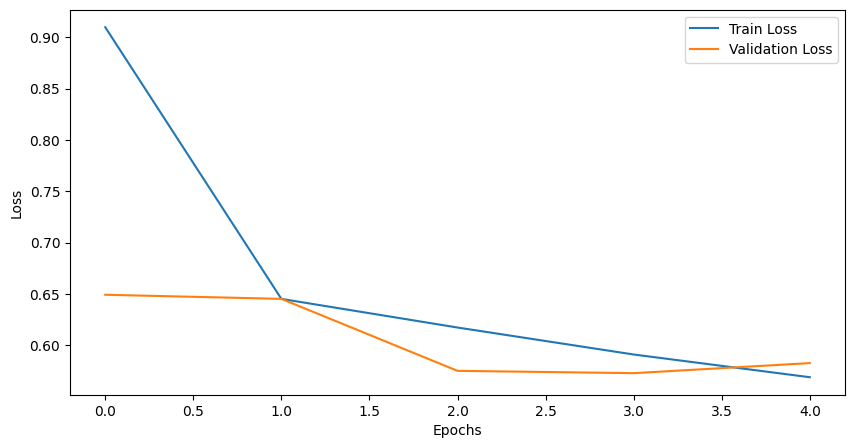

Test Loss: 0.5599560141563416


In [48]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test the model on test data and show the loss
test_loss = []
for step in range(len(test_files) // BATCH_SIZE):
    cover_batch, secret_batch = next(test_data)
    hiding_output, reveal_output = model(secret_batch, cover_batch)
    loss, secret_ssim, cover_ssim, cover_dist = get_loss_op(secret_batch, reveal_output, cover_batch, hiding_output, beta=BETA, gamma=GAMMA)
    test_loss.append(loss.numpy())

print(f'Test Loss: {np.mean(test_loss)}')

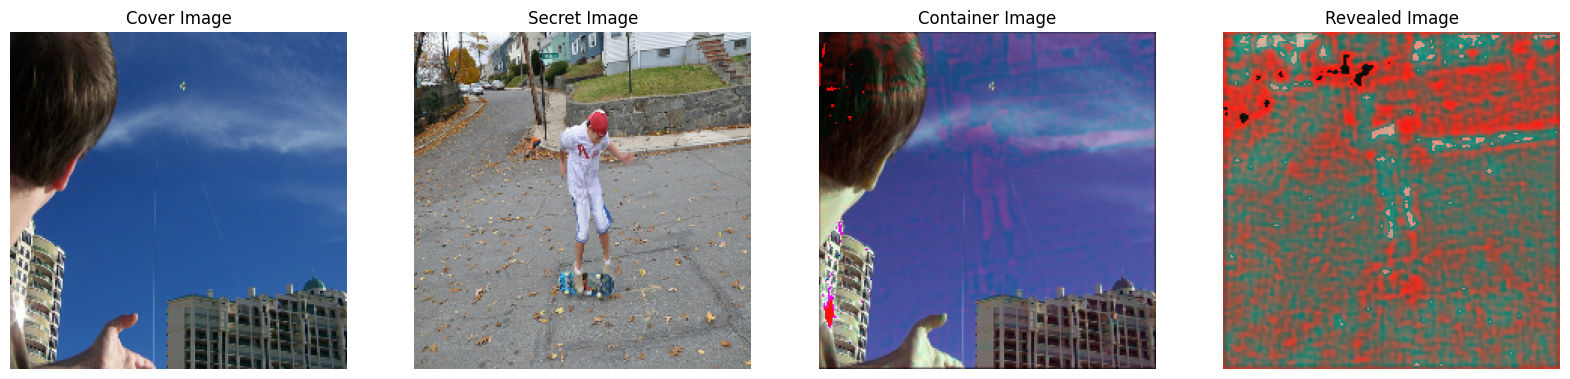

In [49]:
# Define load_image function (assuming it's defined elsewhere)
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to (224, 224)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image

# Define load_data generator function
def load_data(files_list, batch_size, seed=None):
    if seed is not None:
        random.seed(seed)  # Set the random seed for reproducibility
    while True:
        batch_cover = []
        batch_secret = []
        for _ in range(batch_size):
            img_secret_path = random.choice(files_list)
            img_cover_path = random.choice(files_list)

            img_secret = load_image(img_secret_path)
            img_cover = load_image(img_cover_path)

            batch_cover.append(img_cover)
            batch_secret.append(img_secret)

        yield tf.stack(batch_cover), tf.stack(batch_secret)

BATCH_SIZE = 32

########## SET ANY RANDOM SEED VALUE TO LOCK THAT BATCH OF SECRET AND COVER IMAGE SET ###########
SEED = 5

# Function to denormalize image batch
def denormalize_batch(image_batch):
    return image_batch * 255.0

# Function to display images
def display_images(cover, secret, container, revealed):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(denormalize_batch(cover).astype(np.uint8))  # Convert to numpy and denormalize
    axs[0].set_title('Cover Image')
    axs[0].axis('off')

    axs[1].imshow(denormalize_batch(secret).astype(np.uint8))  # Convert to numpy and denormalize
    axs[1].set_title('Secret Image')
    axs[1].axis('off')

    axs[2].imshow(denormalize_batch(container).astype(np.uint8))  # Convert to numpy and denormalize
    axs[2].set_title('Container Image')
    axs[2].axis('off')

    axs[3].imshow(denormalize_batch(revealed).astype(np.uint8))  # Convert to numpy and denormalize
    axs[3].set_title('Revealed Image')
    axs[3].axis('off')

    plt.show()

# Example of how to use itertools.islice with your generator
train_data = load_data(train_files, BATCH_SIZE, seed=SEED)
for covers, secrets in islice(train_data, 1):
    hiding_output, reveal_output = model(secrets, covers)

    # Squeeze the dimensions to remove single-dimensional entries
    cover = np.squeeze(covers[0].numpy())  # Convert to numpy array and select first image in batch
    secret = np.squeeze(secrets[0].numpy())  # Convert to numpy array and select first image in batch

    # Display the images
    display_images(cover, secret, hiding_output[0].numpy(), reveal_output[0].numpy())
    break  # Stop iteration after the first batch
